In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten
from tensorflow.keras.regularizers import l2

from utils import INPUT_SHAPE, batch_generator

(array([  2.,   3.,   6.,   8.,  11.,  11.,  15., 246.,   0.,   2.]),
 array([-0.9000002 , -0.78500018, -0.67000016, -0.55500014, -0.44000012,
        -0.3250001 , -0.21000008, -0.09500006,  0.01999996,  0.13499998,
         0.25      ]),
 <BarContainer object of 10 artists>)

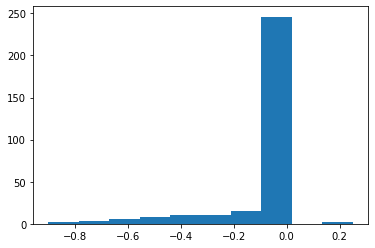

In [3]:
# Thư mục để dữ liệu
data_dir = 'dataset'
# Đọc file driving_log.csv với các cột tương ứng
data_df = pd.read_csv(os.path.join(os.getcwd(), data_dir, 'driving_log.csv'), names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

# Lấy đường dẫn đến ảnh ở camera giữa, trái, phải
X = data_df[['center', 'left', 'right']].values
# Lấy góc lái của ô tô
y = data_df['steering'].values

# Vẽ histogram dữ liệu
plt.hist(y)

(array([  2.,   3.,   6.,   8.,  11.,  11.,  15., 246.,   0.,   2.]),
 array([-0.9000002 , -0.78500018, -0.67000016, -0.55500014, -0.44000012,
        -0.3250001 , -0.21000008, -0.09500006,  0.01999996,  0.13499998,
         0.25      ]),
 <BarContainer object of 10 artists>)

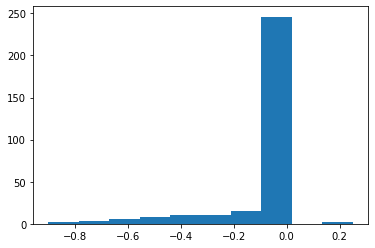

In [4]:
# Loại bỏ và chỉ lấy 1000 dữ liệu có góc lái ở 0
pos_zero = np.array(np.where(y==0)).reshape(-1, 1)
pos_none_zero = np.array(np.where(y!=0)).reshape(-1, 1)
np.random.shuffle(pos_zero)
pos_zero = pos_zero[:1000]

pos_combined = np.vstack((pos_zero, pos_none_zero))
pos_combined = list(pos_combined)

y = y[pos_combined].reshape(len(pos_combined))
X = X[pos_combined, :].reshape((len(pos_combined), 3))

# After process
plt.hist(y)

In [5]:
# Chia ra training set va validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
# Xay dung model
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24, 5, 2, activation='elu'))
model.add(Conv2D(36,5,2, activation="elu"))
model.add(Conv2D(48,5,2, activation="elu"))
model.add(Conv2D(64,3, activation="elu"))
model.add(Conv2D(64, 3, activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0

In [7]:
nb_epoch = 10
samples_per_epoch = 1000
batch_size = 32
save_best_only = True
learning_rate = 1e-4

# Checkpoint này để nói cho model lưu lại model nếu validation loss thấp nhất
checkpoint = ModelCheckpoint('models/model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=save_best_only,
                                 mode='auto')

# Dùng mean_squrared_error làm loss function
model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))

# Train model
H = model.fit_generator(batch_generator(data_dir, X_train, y_train, batch_size, True),
                    steps_per_epoch = samples_per_epoch,
                    epochs = nb_epoch,
                    verbose=1,
                    callbacks=[checkpoint],
                    validation_data=batch_generator(data_dir, X_valid, y_valid, batch_size, False),
                    validation_steps=len(X_valid),
                    max_queue_size=10,
                    )

/home/huuthang_at/.local/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/home/huuthang_at/.local/lib/python3.9/site-packages/keras/engine/training.py:1977: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1000/1000 [==============================] - 121s 120ms/step - loss: 0.0411 - val_loss: 0.0277
Epoch 2/10
1000/1000 [==============================] - 125s 125ms/step - loss: 0.0282 - val_loss: 0.0244
Epoch 3/10
1000/1000 [==============================] - 123s 123ms/step - loss: 0.0246 - val_loss: 0.0263
Epoch 4/10
1000/1000 [==============================] - 124s 124ms/step - loss: 0.0242 - val_loss: 0.0218
Epoch 5/10
1000/1000 [==============================] - 125s 125ms/step - loss: 0.0230 - val_loss: 0.0239
Epoch 6/10
1000/1000 [==============================] - 119s 119ms/step - loss: 0.0230 - val_loss: 0.0259
Epoch 7/10
1000/1000 [==============================] - 114s 114ms/step - loss: 0.0223 - val_loss: 0.0283
Epoch 8/10
1000/1000 [==============================] - 113s 113ms/step - loss: 0.0217 - val_loss: 0.0238
Epoch 9/10
1000/1000 [==============================] - 113s 113ms/step - loss: 0.0209 - val_loss: 0.0249
Epoch 10/10
1000/1000 [=======================